<a href="https://colab.research.google.com/github/kalyani-m-g/CODSOFT/blob/main/codsoft_task3_kalyani_m_g.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub


In [ ]:
import kagglehub
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [ ]:
path = kagglehub.dataset_download("shantanudhakadd/bank-customer-churn-prediction")
print("Dataset path:", path)


100%|██████████| 262k/262k [00:00<00:00, 800kB/s]

Extracting files...
Dataset path: /root/.cache/kagglehub/datasets/shantanudhakadd/bank-customer-churn-prediction/versions/1


In [ ]:
df = pd.read_csv(f"{path}/Churn_Modelling.csv")
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df.drop(columns=["RowNumber", "CustomerId", "Surname"], inplace=True)


In [ ]:
df = pd.get_dummies(df, columns=["Geography", "Gender"], drop_first=True)


In [ ]:
X = df.drop("Exited", axis=1)
y = df["Exited"]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

lr_preds = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_preds))


Logistic Regression Accuracy: 0.808


In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42
)

rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))


Random Forest Accuracy: 0.8685


In [ ]:
gb = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.05,
    random_state=42
)

gb.fit(X_train, y_train)
gb_preds = gb.predict(X_test)

print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_preds))


Gradient Boosting Accuracy: 0.87


In [ ]:
print(classification_report(y_test, gb_preds))
print(confusion_matrix(y_test, gb_preds))


              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.80      0.48      0.60       407

    accuracy                           0.87      2000
   macro avg       0.84      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000

[[1544   49]
 [ 211  196]]


In [ ]:
param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4]
}




In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rand_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

rand_search.fit(X_train, y_train)
print("Best parameters:", rand_search.best_params_)
best_gb = rand_search.best_estimator_


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.79      0.49      0.60       407

    accuracy                           0.87      2000
   macro avg       0.84      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000

Confusion Matrix:
[[1541   52]
 [ 208  199]]
ROC-AUC Score: 0.8708307691358538


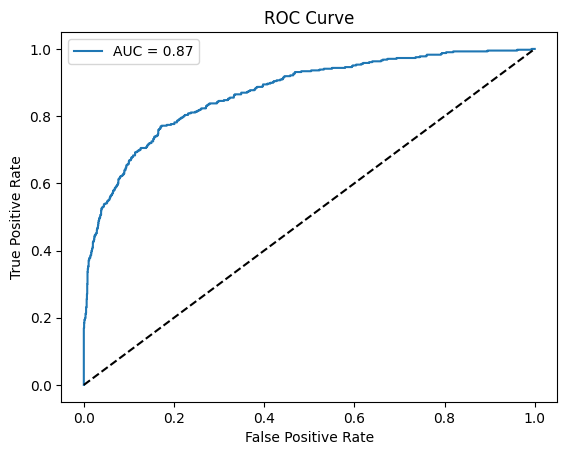

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


y_pred = best_gb.predict(X_test)
y_pred_proba = best_gb.predict_proba(X_test)[:,1]


print("Accuracy:", best_gb.score(X_test, y_test))
print(classification_report(y_test, y_pred))


print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)


fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


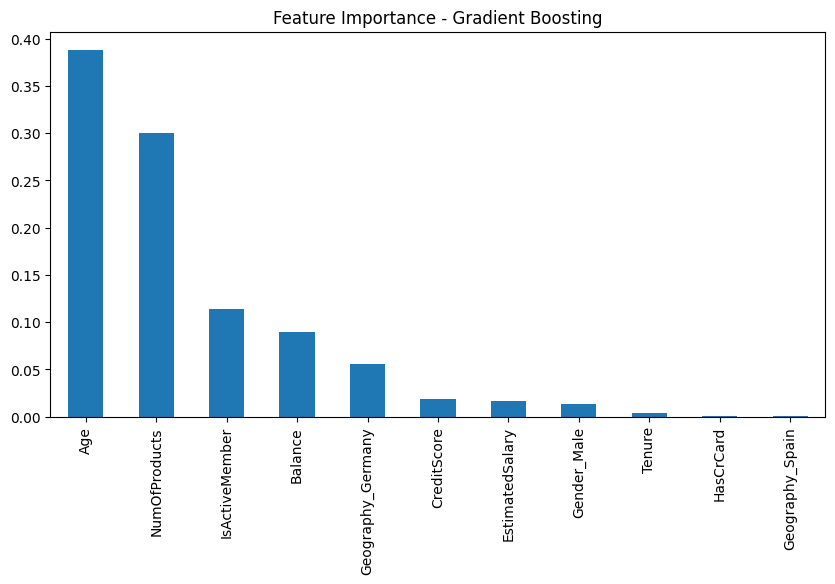

In [ ]:
import pandas as pd

feature_names = X.columns
importances = pd.Series(best_gb.feature_importances_, index=feature_names)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("Feature Importance - Gradient Boosting")
plt.show()


In [ ]:
import joblib


joblib.dump(best_gb, "churn_model.pkl")

joblib.dump(scaler, "scaler.pkl")
print("Model and scaler saved ✅")


Model and scaler saved ✅


In [ ]:
# Example new customer
new_customer = np.array([[
    600,    # CreditScore
    40,     # Age
    3,      # Tenure
    60000,  # Balance
    2,      # NumOfProducts
    1,      # HasCrCard
    1,      # IsActiveMember
    50000,  # EstimatedSalary
    0,      # Geography_Germany
    1,      # Geography_Spain
    1       # Gender_Male
]])

new_customer_scaled = scaler.transform(new_customer)
prediction = best_gb.predict(new_customer_scaled)
proba = best_gb.predict_proba(new_customer_scaled)[0][1]

print(f"Churn Probability: {proba*100:.2f}%")
print("Prediction:", "❌ Will Churn" if prediction[0]==1 else "✅ Will Stay")


Churn Probability: 5.10%
Prediction: ✅ Will Stay


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
#  User Input Based Churn Prediction

def get_int(prompt, min_val=None, max_val=None):
    while True:
        try:
            value = int(input(prompt))
            if min_val is not None and value < min_val:
                raise ValueError
            if max_val is not None and value > max_val:
                raise ValueError
            return value
        except ValueError:
            print(" Invalid input. Please enter a valid integer.")

def get_float(prompt, min_val=None):
    while True:
        try:
            value = float(input(prompt))
            if min_val is not None and value < min_val:
                raise ValueError
            return value
        except ValueError:
            print(" Invalid input. Please enter a valid number.")

print("\n Enter customer details for churn prediction:\n")

credit_score = get_int("Credit Score (300–900): ", 300, 900)
age = get_int("Age (18–100): ", 18, 100)
tenure = get_int("Tenure (0–10): ", 0, 10)
balance = get_float("Account Balance: ", 0)
num_products = get_int("Number of Products (1–4): ", 1, 4)
has_card = get_int("Has Credit Card? (1=Yes, 0=No): ", 0, 1)
is_active = get_int("Is Active Member? (1=Yes, 0=No): ", 0, 1)
salary = get_float("Estimated Salary: ", 0)

print("\nGeography:")
print("1. France\n2. Germany\n3. Spain")
geo = get_int("Choose (1–3): ", 1, 3)

gender = get_int("Gender (1=Male, 0=Female): ", 0, 1)


geo_germany = 1 if geo == 2 else 0
geo_spain = 1 if geo == 3 else 0


new_customer = np.array([[
    credit_score,
    age,
    tenure,
    balance,
    num_products,
    has_card,
    is_active,
    salary,
    geo_germany,
    geo_spain,
    gender
]])


new_customer_scaled = scaler.transform(new_customer)

prediction = best_gb.predict(new_customer_scaled)
proba = best_gb.predict_proba(new_customer_scaled)[0][1]

print("\n RESULT")
print(f"Churn Probability: {proba*100:.2f}%")
print("Prediction:", "❌ Will Churn" if prediction[0] == 1 else "✅ Will Stay")



 Enter customer details for churn prediction:

Credit Score (300–900): 750
Age (18–100): 32
Tenure (0–10): 6
Account Balance: 20000
Number of Products (1–4): 2
Has Credit Card? (1=Yes, 0=No): 1
Is Active Member? (1=Yes, 0=No): 1
Estimated Salary: 60000

Geography:
1. France
2. Germany
3. Spain
Choose (1–3): 1
Gender (1=Male, 0=Female): 1

 RESULT
Churn Probability: 3.18%
Prediction: ✅ Will Stay


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
